In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [100]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from itertools import product
import itertools
import pickle

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
# Set a professional style for the plot
plt.style.use('_mpl-gallery')
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from picking.p_picking import p_picking_all, p_picking_each, p_picking_val
from picking.utils_energy import *
from picking.utils_general import *
from picking.plot import *


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/home/lptv/anaconda3/envs/trigger_env/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

In [4]:
def find_files(path, extensions):
    '''
    Entrega de vuelta un diccionario con la extensión del archivo como llave, y el path a cada archivo como valor

    '''
    file_list = {ext: [] for ext in list(extensions)}
    for root, dirs, files in os.walk(path):
        for file in files:
            for ext in extensions:
                if file.endswith(ext):
                    file_list[ext].append(os.path.join(root, file))

    return file_list


def sort_files(file_dic, extension):
    '''
    Junta los archivos por carpeta y canal. Queda un diccionario que tiene como llave la carpeta y el canal, 
    y como valor una lista con los paths a los archivos de esa carpeta y canal.   
    '''
    # Diccionario para almacenar los archivos por carpeta y canal
    grouped_files = defaultdict(list)
    key_names = []
    
    # Ordenar los archivos alfabéticamente antes de procesarlos
    sorted_files = sorted(file_dic[extension])
    
    for file in sorted_files:
        # Extraer la carpeta y el canal del path del archivo
        parts = os.path.split(file)
        folder = parts[0]  # La carpeta es el primer elemento en el path
        channel = parts[1].split('_')[0]  # El canal es el primer elemento en el nombre del archivo
        key = os.path.join(folder, channel)
        if [key] not in key_names:
            key_names.append([key])
        # Agrupar los archivos
        grouped_files[key].append(file)

    key_names = list(itertools.chain(*key_names))
    return grouped_files, key_names




In [5]:
files_bhz = find_files("señales_sismos/BHZ", ['.mseed'])
files_bhz_ch, key_names_bhz = sort_files(files_bhz, '.mseed')

<img src="diagrama.png">

# 1. Preprocesamiento de las trazas

## 1.1. Lectura de las trazas sísmicas

***Ojo que la forma en que se ordenan las cosas es diferente en windows y linux, no se por què, ver esto***
- En la diferencia entre los archivos sta-lta.ipynb y energy.ipynb se van a evidencia las diferencias.
- Una es en la // de las funciones find_files y sort_files
- La otra es en aca abajo en como quedan ordenadas las trazas. AC04 quedan en 2 y CO05 queda en 0.

In [6]:
#estación AC04
AC04_st = files_bhz_ch[key_names_bhz[0]]
st_AC04_raw = read(AC04_st[0])
st_AC04_raw += read(AC04_st[1])
st_AC04_raw += read(AC04_st[2])


#estación adyacente 1: AC05
AC05_st = files_bhz_ch[key_names_bhz[1]]
st_AC05_raw = read(AC05_st[0])
st_AC05_raw += read(AC05_st[1])
st_AC05_raw += read(AC05_st[2])


#estación adyacente 2: CO05
CO05_st = files_bhz_ch[key_names_bhz[2]]
st_CO05_raw = read(CO05_st[0])
st_CO05_raw += read(CO05_st[1])
st_CO05_raw += read(CO05_st[2])

#estación adyacente 3: CO10
CO10_st = files_bhz_ch[key_names_bhz[3]]
st_CO10_raw = read(CO10_st[0])
st_CO10_raw += read(CO10_st[1])
st_CO10_raw += read(CO10_st[2])

### 1.1.1. Visualización de la señal AC04

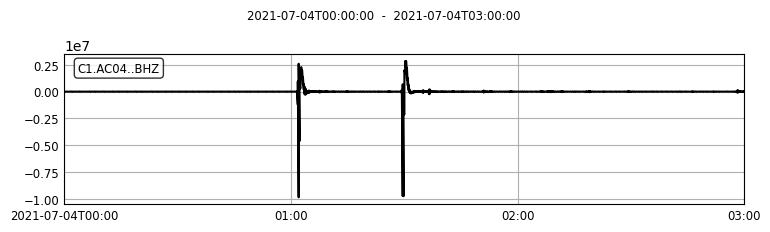

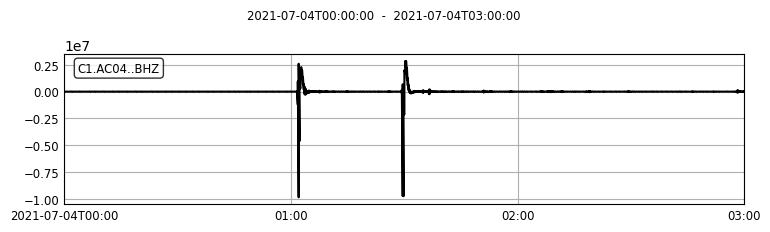

In [7]:
st_AC04_raw[2].plot(startime = st_AC04_raw[2].stats.starttime + 60*60 , endtime = st_AC04_raw[2].stats.starttime + 60*60*3)

## 1.2. Eliminación de respuesta de instrumentos

In [8]:
remove_AC04 = os.path.join("inventory", "C1_AC04.xml")
remove_AC05 = os.path.join("inventory", "C1_AC05.xml")
remove_CO05 = os.path.join("inventory", "C1_CO05.xml")
remove_CO10 = os.path.join("inventory", "C1_CO10.xml")

In [9]:
st_AC04_resp = st_AC04_raw.copy()
st_AC05_resp = st_AC05_raw.copy()
st_CO05_resp = st_CO05_raw.copy()
st_CO10_resp = st_CO10_raw.copy()

In [10]:
st_AC04_removed = remove_response(st_AC04_resp.select(channel='BHZ')[0], remove_AC04 , 'obspy')
st_AC05_removed = remove_response(st_AC05_resp.select(channel='BHZ')[0], remove_AC05 , 'obspy')
st_CO05_removed = remove_response(st_CO05_resp.select(channel='BHZ')[0], remove_CO05 , 'obspy')
st_CO10_removed = remove_response(st_CO10_resp.select(channel='BHZ')[0], remove_CO10 , 'obspy')

st_AC04_resp[2] = st_AC04_removed
st_AC05_resp[2] = st_AC05_removed
st_CO05_resp[2] = st_CO05_removed 
st_CO10_resp[2] = st_CO10_removed

assert(st_AC04_resp.select(channel='BHZ')[0] == st_AC04_removed)
assert(st_AC05_resp.select(channel='BHZ')[0] == st_AC05_removed)
assert(st_CO05_resp.select(channel='BHZ')[0] == st_CO05_removed)
assert(st_CO10_resp.select(channel='BHZ')[0] == st_CO10_removed)

### 1.2.1. Visualización señal sin respuesta instrumental

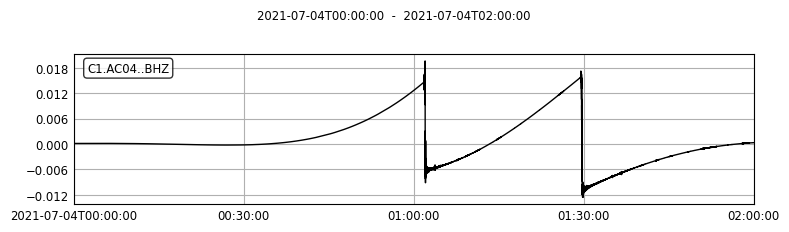

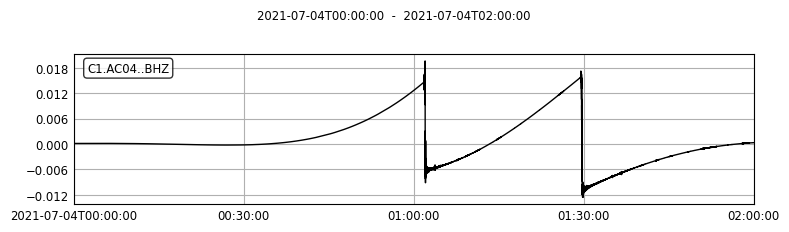

In [11]:
st_AC04_resp[2].plot(startime = st_AC04_resp[2].stats.starttime + 60*60, endtime = st_AC04_resp[2].stats.starttime + 2*60*60)

## 1.3. Filtro pasa banda

In [12]:
st_AC04 = st_AC04_resp.copy()
st_AC05 = st_AC05_resp.copy()
st_CO05 = st_CO05_resp.copy()
st_CO10 = st_CO10_resp.copy()

In [13]:
st_AC04.filter('bandpass', freqmin=4.0, freqmax=10.0) 
st_AC05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO05.filter('bandpass', freqmin=4.0, freqmax=10.0)
st_CO10.filter('bandpass', freqmin=4.0, freqmax=10.0)

3 Trace(s) in Stream:
C1.CO10..BHE | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHN | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples
C1.CO10..BHZ | 2021-07-04T00:00:00.000000Z - 2021-07-05T00:00:00.000000Z | 40.0 Hz, 3456001 samples

### 1.3.1 Visualización señal filtrada 

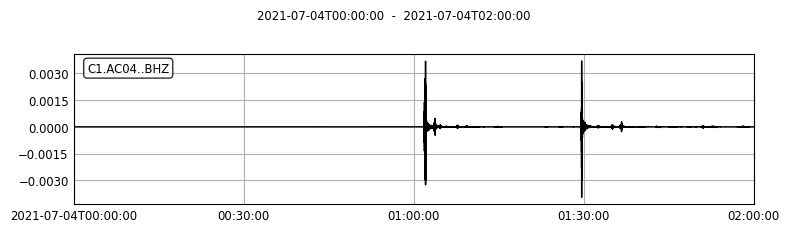

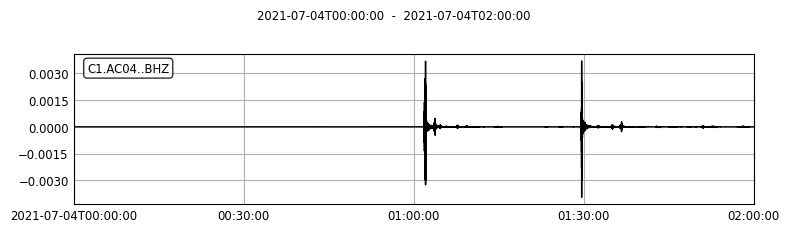

In [14]:
st_AC04[2].plot(startime = st_AC04[2].stats.starttime, endtime = st_AC04[2].stats.starttime + 60*60*2)

# 2. Cálculo de la energía para los eventos mayores que 4 en la estación más cercana al evento.

## 2.1. Cargamos el txt con los eventos mayores que 4. 

In [15]:
# Ruta al archivo txt
#file_path = "times_events_24hrs_sup40.txt"  
file_path = "catalog_new_events.txt"

# Lee los datos
df = pd.read_csv(file_path)

In [16]:
df

,Fecha UTC ORIGEN,Magnitud,Inicio_CO10,Inicio_AC04,Inicio_AC05,Inicio_CO05
0,2021-07-04T01:01:37.000000Z,5.9,2021-07-04T01:01:45.750000Z,2021-07-04T01:01:50.423000Z,2021-07-04T01:01:57.030000Z,2021-07-04T01:01:57.150000Z
1,2021-07-04T01:29:15.000000Z,5.8,2021-07-04T01:29:24.500000Z,2021-07-04T01:29:28.187000Z,2021-07-04T01:29:35.186000Z,2021-07-04T01:29:35.991000Z
2,2021-07-04T01:34:42.000000Z,4.0,2021-07-04T01:34:51.000000Z,2021-07-04T01:34:53.428000Z,2021-07-04T01:35:01.173000Z,2021-07-04T01:35:02.659000Z
3,2021-07-04T01:36:16.000000Z,4.1,2021-07-04T01:36:27.571000Z,2021-07-04T01:36:30.489000Z,2021-07-04T01:36:37.501000Z,2021-07-04T01:36:37.378000Z
4,2021-07-04T02:57:48.000000Z,4.6,2021-07-04T02:57:57.904000Z,2021-07-04T02:58:01.510000Z,2021-07-04T02:58:08.730000Z,2021-07-04T02:58:09.220000Z
5,2021-07-04T04:03:22.000000Z,4.4,2021-07-04T04:03:31.701000Z,2021-07-04T04:03:35.638000Z,2021-07-04T04:03:42.773000Z,2021-07-04T04:03:43.100000Z
6,2021-07-04T04:08:09.000000Z,4.0,2021-07-04T04:08:18.682000Z,2021-07-04T04:08:22.566000Z,2021-07-04T04:08:30.000000Z,2021-07-04T04:08:30.073000Z
7,2021-07-04T15:05:28.000000Z,4.6,2021-07-04T15:05:37.674000Z,2021-07-04T15:05:41.913000Z,2021-07-04T15:05:48.934000Z,2021-07-04T15:05:49.083000Z
8,2021-07-04T15:57:11.000000Z,4.3,2021-07-04T15:57:21.000000Z,2021-07-04T15:57:23.828000Z,2021-07-04T15:57:30.855000Z,2021-07-04T15:57:32.551000Z
9,2021-07-04T19:39:24.000000Z,4.0,2021-07-04T19:39:33.100000Z,2021-07-04T19:39:38.212000Z,2021-07-04T19:39:44.529000Z,2021-07-04T19:39:44.420000Z


## 2.2 Guardamos en un diccionario la estación y tiempo de detección del evento en esa estación, para todos los eventos

In [17]:
# Inicializa un diccionario vacío para guardar los resultados
resultados = {}

stations_names = ['CO10','AC04', 'AC05', 'CO05']

# Itera sobre cada fila del DataFrame
for i, fila in df.iterrows():
    # Obtiene las distancias a las estaciones
    #distancias = [fila['Distancia a estación CO10'], fila['Distancia a estación AC04'], fila['Distancia a estación AC05'], fila['Distancia a estación CO05']]
    
    # Obtiene las horas de detección en las estaciones
    horas_deteccion = [fila['Inicio_CO10'], fila['Inicio_AC04'], fila['Inicio_AC05'], fila['Inicio_CO05']]
    
    # Encuentra el índice de la estación más cercana
    indice_estacion_cercana = horas_deteccion.index(min(horas_deteccion))
    
    # Guarda la estación más cercana y la hora de detección correspondiente en el diccionario
    resultados[i+1] = [stations_names[indice_estacion_cercana], horas_deteccion[indice_estacion_cercana]]

## 2.3. Creamos una lista con el tiempo de partida de cada evento para la estación más cercana y una lista con el nombre de la estación más cercana para cada evento

In [18]:
start_time = [UTCDateTime(resultados[clave][1]) for clave in sorted(resultados)]
closest_st_names = [resultados[clave][0] for clave in sorted(resultados)]

## 2.4. Se selecciona el canal de mayor interes para todas las estaciones

In [19]:
#selecciona el canal BHZ de AC04
st_AC04_BHZ = st_AC04.select(channel='BHZ')
#selecciona el canal BHZ de AC05
st_AC05_BHZ = st_AC05.select(channel='BHZ')
#selecciona el canal BHZ de CO05
st_CO05_BHZ = st_CO05.select(channel='BHZ')
#selecciona el canal BHZ de CO10
st_CO10_BHZ = st_CO10.select(channel='BHZ')

## 2.5 Se guarda en una lista la traza del eje z que corresponde a la estación más cercana para cada evento

In [20]:
# Crear un diccionario para mapear los nombres de las estaciones a las estaciones
stations_dic = {
    'AC04': st_AC04_BHZ[0],
    'AC05': st_AC05_BHZ[0],
    'CO05': st_CO05_BHZ[0],
    'CO10': st_CO10_BHZ[0],
}

# Crear una lista con las estaciones más cercanas para cada evento
closest_sts_tr = [stations_dic[estacion] for estacion in closest_st_names]


## 2.6. Se toma para cada evento un rango de tiempo alrededor de la detección estimada y luego se visualiza

### 2.6.1. Se calcula el término del evento como el 3% de la energía del punto máximo del evento 

Tomamos en un inicio solo los primeros 60 segundos para calcular la energía máxima, de forma contraria, considera eventos futuros como los de máxima energía, quedando la cagadita. En tiempo real esto no sería necesario

Ahora se toma la función anterior para calcular el termino del evento

In [21]:
# Tomamos trazas que parten en el inicio de cada evento y toman todo el resto de la señal 
start_traces = [sts.slice(start) for sts, start in zip(closest_sts_tr, start_time)]

# Se calcula el punto donde cada traza tendría su finalización del evento
end_events_traces = [endpoint_event(st.data)[1] for st in start_traces]


In [22]:
end_events_traces

[1280, 1120, 1600, 1440, 960, 960, 640, 960, 800, 800, 1120]

### 2.6.2. Tomamos desde el incio del evento hasta el fin antes calculado 

In [23]:
pre_event = 0
post_event = end_events_traces
sample_rate = 40
sliced_traces = [traces.slice(start - pre_event, start + post_event[i]/sample_rate) for i, (traces, start) in enumerate(zip(closest_sts_tr, start_time))]


In [ ]:
fig, axs = plt.subplots(len(sliced_traces), 1, figsize=(15, 30), sharex=False)
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    start = mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)
    axs[i].plot(traces.times("matplotlib"), traces.data)
    axs[i].set_title(f'Evento {i+1}. Estación más cercana: {closest_st_names[i]} \nHora de Inicio: {traces.stats.starttime + pre_event}', size=10)
    axs[i].set_ylabel('Amplitud')
    axs[i].set_xlim([axs[i].get_xlim()[0], axs[i].get_xlim()[1]])
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora

    # Convertir UTCDateTime a formato matplotlib
    start= mdates.date2num(traces.stats.starttime.datetime)
    end = mdates.date2num(traces.stats.endtime.datetime)

    # Agregar una línea vertical roja en el tiempo de inicio del evento
    axs[i].axvline(x=start, color='r')

    # Agregar una línea vertical negra en el tiempo de finalización del evento
    axs[i].axvline(x=end, color='k')

plt.show()



In [ ]:
fig = plt.figure(figsize=(15, 75))
gs = gridspec.GridSpec(2*len(sliced_traces), 1, height_ratios=[1,2.2]*len(sliced_traces), width_ratios=[1])
fig.subplots_adjust(hspace = 0.5)

for i, traces in enumerate(sliced_traces):
    # Plot the signal
    ax1 = plt.subplot(gs[2*i])
    ax1.plot(traces.times("matplotlib"), traces.data, color='steelblue', linewidth=1.5)
    ax1.set_title(f'Evento {i+1}. Estación más cercana: {closest_st_names[i]} \nHora de Inicio: {traces.stats.starttime + pre_event} \nHora de Fin: {traces.stats.starttime + post_event[i]/sample_rate}'
                  , size=10, fontweight='bold')
    ax1.set_ylabel('Amplitud', fontsize=10)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Formato de hora
    ax1.grid(True)

    # Plot the spectrogram
    ax2 = plt.subplot(gs[2*i+1])
    fig = traces.spectrogram(show=False, axes=ax2, title='Spectrogram', cmap=cm.jet)
    ax2.set_title('Spectrogram', size=12, fontweight='bold')
    ax2.grid(True)

plt.show()



# 3. Cálculo de la energía y potencia por frames

## 3.1. Se aplica la función de utils_energy para el cálculo de la energía y la potencia

In [26]:
energy_events, power_events = zip(*[energy_power(st.data) for st in sliced_traces])

## 3.2. Visualizamos la energía y la potencia

### 3.2.1. La energía se visualiza para cada frame del evento en el eje x.

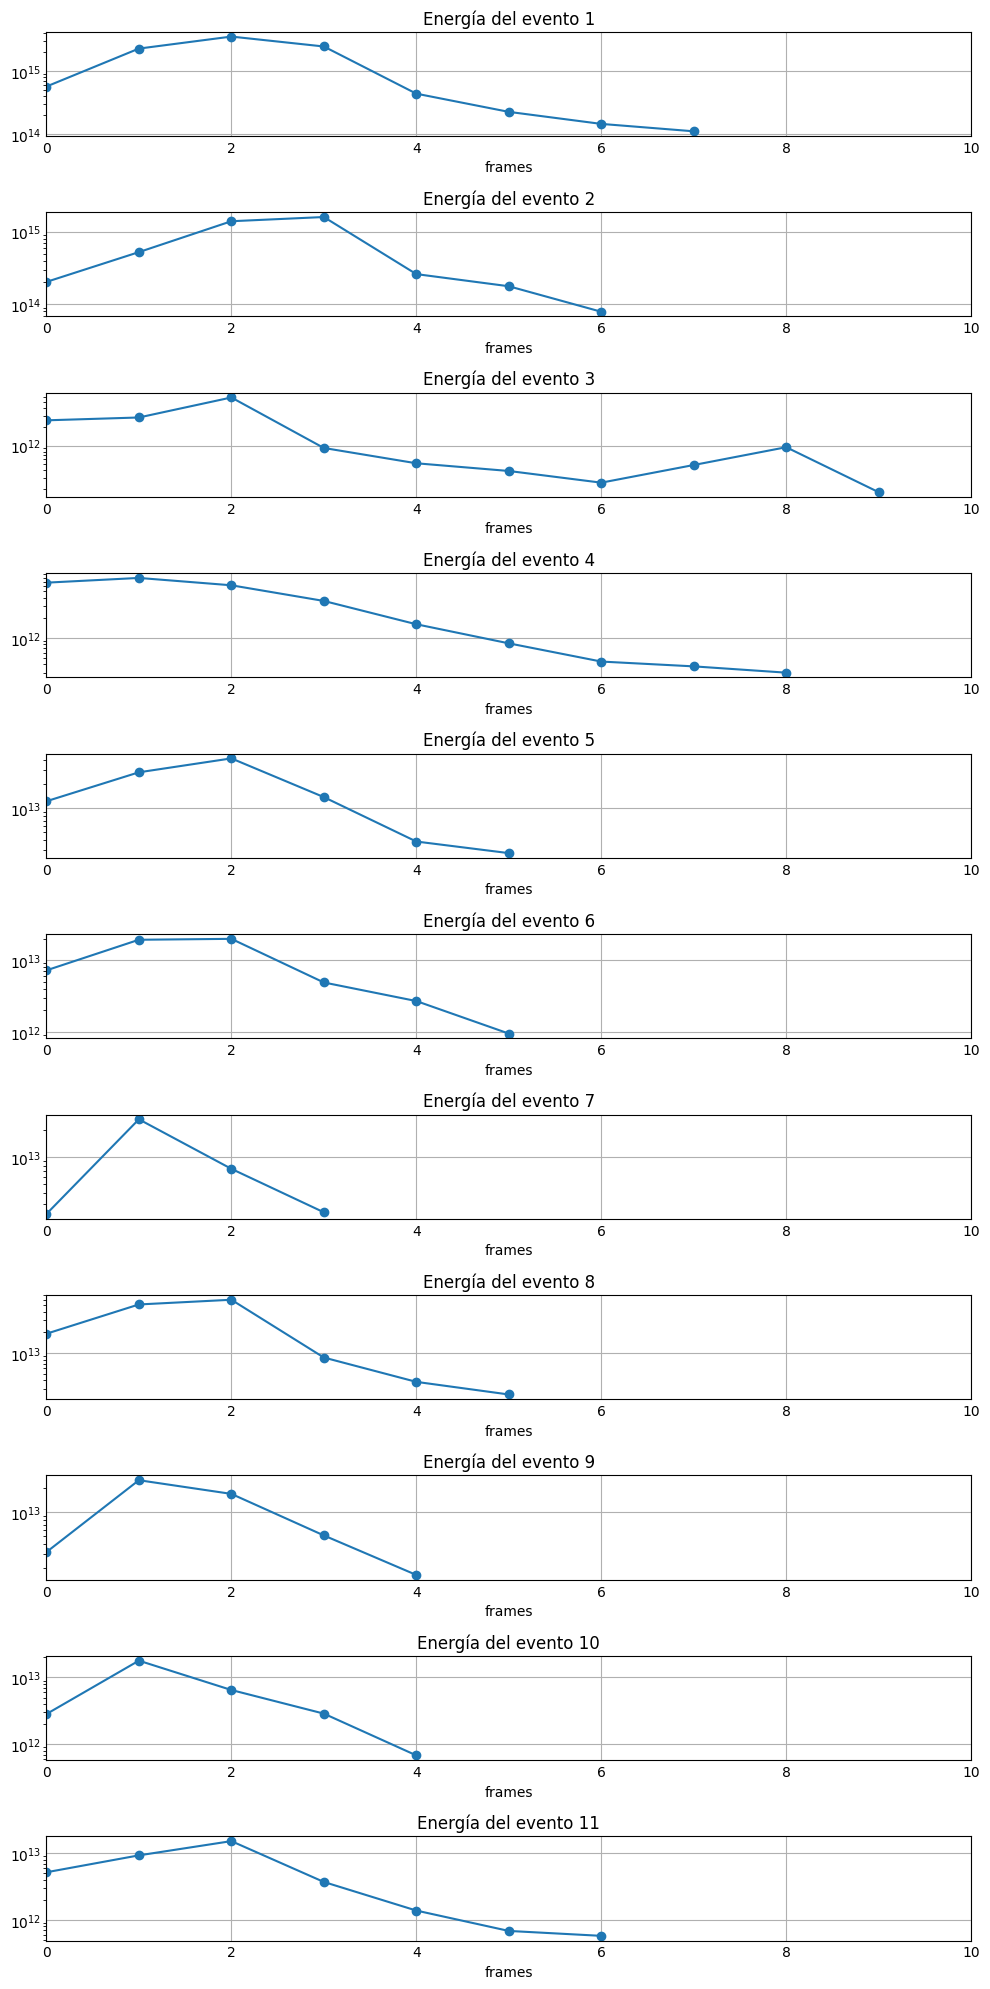

In [27]:
# Crear una figura para los gráficos
plt.figure(figsize=(10, 20))

# Encontrar la longitud máxima en energy_events
max_len = max(len(energ) for energ in energy_events)

# Graficar la energía de cada evento
for i, energ in enumerate(energy_events, start=1):
    plt.subplot(len(energy_events), 1, i)
    plt.plot(energ, 'o-')  # Añadir marcadores a la línea
    plt.yscale('log')  # Cambiar a escala logar
    plt.title(f'Energía del evento {i}', size = 12)
    plt.xlim(0, max_len)  # Establecer la misma longitud del eje x para todos
    plt.xlabel('frames')  # Añadir leyenda al eje x
    plt.tight_layout()

# Mostrar los gráficos
plt.show()



In [ ]:
plot_power_each()

### 3.2.2. Realizamos un histograma de la potencia también por frame (explicación a continuación).

- Estamos considerando entonces (como se puede observar en la función energy_power() antes definida) que la potencia correspondería a la energía del frame dividido en en (largo del frame/frecuencia de muestreo). Esta última razón nos da como resultado 4 segundos, que es el largo del frame que queremos utilizar. Por lo tanto quedaría la energía de cada frame divido por 4 segundos, lo que sería la definición de potencia.

- Entonces, a continuación, si ploteamos el histograma del primer frame, se plotea el primer frame de cada uno de los eventos. **Acá es importante considerar que no todos los eventos tienen igual duración**. En caso de utilizar un n_frames = 2, se toma para cada evento el promedio de la potencia de los frames 1 y 2 (que sería equivalente a calcular la potencia en los dos primeros frames), y así sucesivamente para el resto de los frames.

- En la función plot_power() se puede elegir entre utilizar la potencia normal, o el log de la potencia. Esto último tiene más sentido debido a que se tiene un histograma donde se pueden diferenciar las magnitudes de las potencias y podrían servir para compararlas con eventos menores que 4, o incluso trazas sin eventos.

# 4. Para realizar una comparación consideraremos dos casos:
- Trazas de estaciones con eventos catalogados pero de magnitud menor a 4.
- Trazas de estaciones sin ningún evento catalogado


## 4.1. Trazas con eventos catalogados de magnitud menor a 4

Para esto simplemente se considerarán (de la estación CO10) trazas aleatorias con la condición que no pertenezcan al catálogo general.

In [34]:
events_under_four = "times_events_under_four.txt"
# Lee los datos
df_under_four = pd.read_csv(events_under_four)

### 4.1.2 Guardamos en un diccionario la estación y tiempo de detección del evento en esa estación, para todos los eventos

In [35]:
# Inicializa un diccionario vacío para guardar los resultados
results_under_four = {}

# Itera sobre cada fila del DataFrame
for i, row in df_under_four.iterrows():
    # Obtiene las distancias a las estaciones
    #distancias = [fila['Distancia a estación CO10'], fila['Distancia a estación AC04'], fila['Distancia a estación AC05'], fila['Distancia a estación CO05']]
    
    # Obtiene las horas de detección en las estaciones
    detecction_times = [row['Inicio_CO10'], row['Inicio_AC04'], row['Inicio_AC05'], row['Inicio_CO05']]
    
    # Encuentra el índice de la estación más cercana
    idx_nearest_st = detecction_times.index(min(detecction_times))
    
    # Guarda la estación más cercana y la hora de detección correspondiente en el diccionario
    results_under_four[i+1] = [stations_names[idx_nearest_st], detecction_times[idx_nearest_st]]

### 4.1.3. Creamos una lista con el tiempo de partida de cada evento para la estación más cercana y una lista con el nombre de la estación más cercana para cada evento

In [36]:
start_time_under_four = [UTCDateTime(results_under_four[clave][1]) for clave in sorted(results_under_four)]
closest_sts_under_four = [results_under_four[clave][0] for clave in sorted(results_under_four)]

### 4.1.4. Se guarda en una lista la traza del eje z que corresponde a la estación más cercana para cada evento

In [37]:
closest_sts_tr_under_four = [stations_dic[estacion] for estacion in closest_sts_under_four]

### 4.1.5. Igual que antes se calcula el término del evento como el 3% de la energía del punto máximo del evento y se toma la traza hasta ese punto

In [38]:
# Tomamos trazas que parten en el inicio de cada evento y toman todo el resto de la señal 
start_tr_under_four = [sts.slice(start) for sts, start in zip(closest_sts_tr_under_four, start_time_under_four)]

# Se calcula el punto donde cada traza tendría su finalización del evento
end_events_tr_under_four = [endpoint_event(st.data)[1] for st in start_tr_under_four]

In [39]:
pre_event_under_four = 0
post_event_under_four = end_events_tr_under_four
sample_rate = 40
sliced_traces_under_four = [traces.slice(start - pre_event_under_four, start + post_event_under_four [i]/sample_rate) for i, (traces, start) in enumerate(zip(closest_sts_tr_under_four, start_time_under_four))]

### 4.1.6. Hacemos el cálculo de la energía y potencia de estas señales. Luego se muestra el histograma de la potencia.

In [40]:
energy_events_under_four, power_events_under_four = zip(*[energy_power(st.data) for st in sliced_traces_under_four])

## 4.2. Trazas aleatorias tomadas de la estación CO10 sin eventos

### 4.2.1. Partimos elegigiendo trazas donde no existan eventos. Tomaremos de forma aleatoria 50 intervalos de 1 minuto donde no existan eventos

In [117]:
no_event_df = pd.read_csv('no_event_intervals.txt')

random_intervals = no_event_df.sample(n=50, random_state=1)

In [118]:
# Convertir las columnas 'Start' y 'End' a datetime
random_intervals['Start'] = pd.to_datetime(random_intervals['Start'])
random_intervals['End'] = pd.to_datetime(random_intervals['End'])

# Crear las listas start_times_no_events y end_time_no_events
start_times_no_events = random_intervals['Start'].dt.strftime('%Y-%m-%dT%H:%M:%S.000000Z').tolist()
end_time_no_events = random_intervals['End'].dt.strftime('%Y-%m-%dT%H:%M:%S.000000Z').tolist()

start_times_no_events = [UTCDateTime(time) for time in start_times_no_events]
end_time_no_events = [UTCDateTime(time) for time in end_time_no_events]
start_times_no_events.sort()
end_time_no_events.sort()


### 4.2.3. Se hace el slice de las trazas para la estación CO10. 

In [132]:
station_no_event = ['CO10']*1000
closest_sts_tr_no_event = [stations_dic[estacion] for estacion in station_no_event]

sliced_traces_no_event = [traces.slice(start, start + 60) for traces, start in zip(closest_sts_tr_no_event, start_times_no_events)]


In [161]:
energy_events_no_events, power_events_no_event = zip(*[energy_power(st.data) for st in sliced_traces_no_event])
power_events_all = [power_events, power_events_under_four, power_events_no_event]
event_type = ['$M \geq 4$', '$M < 4$', 'sin eventos']

## 4.3. Comparación a través del histograma de 3 casos diferentes

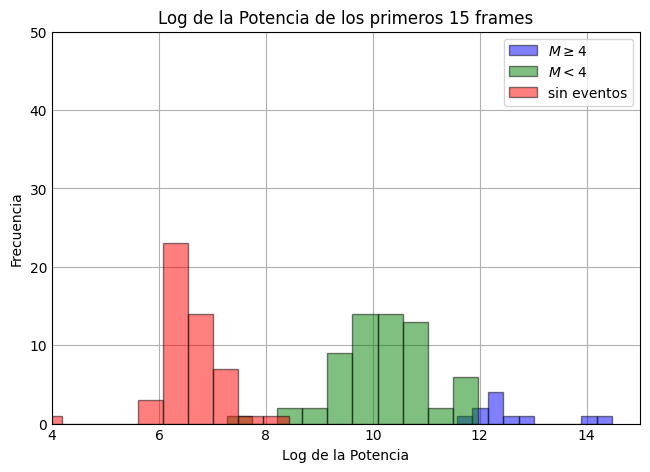

In [162]:
plot_power(power_events_all, n_frames=15, use_log=True, event_type=event_type)


# 5. Gráfico de curvas ROC y matriz de confusión para validación según el criterio de POTENCIA

Como para realizar esto se necesitan tener solo dos clases, del tipo "sí" y "no", no podemos llegar y usar lo que tenemos antes directamente. Esto ya que antes consideramos 3 clases distintas. Debido a esto, se considera desde ahora dos casos de separación:
1) Sismo vs No-Sismo
2) Sismo M>4 vs No-Sismo M>4 (acá entran tanto sismos menores que 4 como cosas que no son sismos)

## 5.1. Sismo vs No-Sismo

### 5.1.1. Comenzamos definiendo las clases y asignando los labels. Consideramos un sismo como 1, y un no sismo como 0

In [163]:

classes = ['Seismic Event', 'No Seismic Event']

power_events_flattened = [np.concatenate(events) for events in power_events_all]
data = np.concatenate(power_events_flattened)
# Como estamos trabajando con el log de 10 antes, lo hacemos tambien acá, hace todo más bonito jjjjjeee
log_data = np.log10(data)

labels = np.concatenate([np.ones(len(power_events_flattened[0])), np.ones(len(power_events_flattened[1])), np.zeros(len(power_events_flattened[2]))])


### 5.1.2. Se realiza el cálculo de la curva ROC y el AUC usando sklearn. Luego esto se plotea

In [164]:
fpr, tpr, thresholds = roc_curve(labels, log_data)

roc_auc = auc(fpr, tpr)


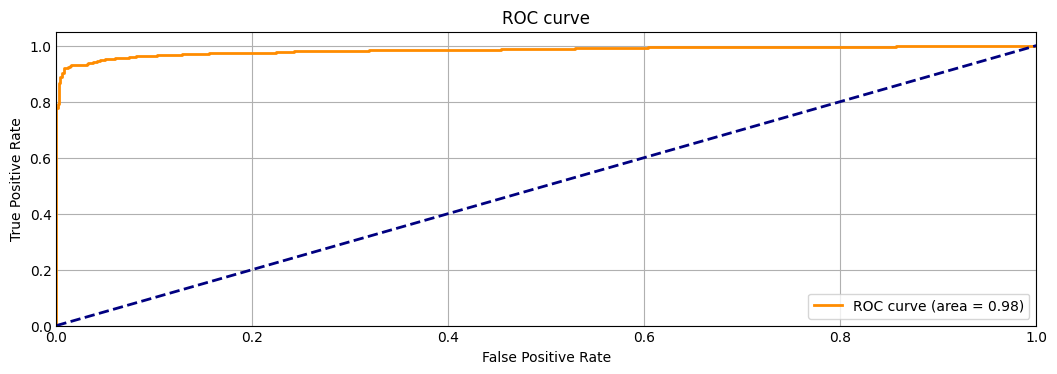

In [169]:
plt.figure(figsize=(10,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


### 5.1.3. Lo siguiente se hace para encontrar el valor del umbral óptimo. 

In [171]:
# Se calcula la distancia de cada punto de la curva ROC a la esquina izquierda superior
distances = np.sqrt((0 - fpr)**2 + (1 - tpr)**2)

index = np.argmin(distances)

optimal_threshold = thresholds[index]

print("Umbral óptimo", optimal_threshold)


Umbral óptimo 7.590396599057258


### 5.1.4. Se plotea la matriz de confusión

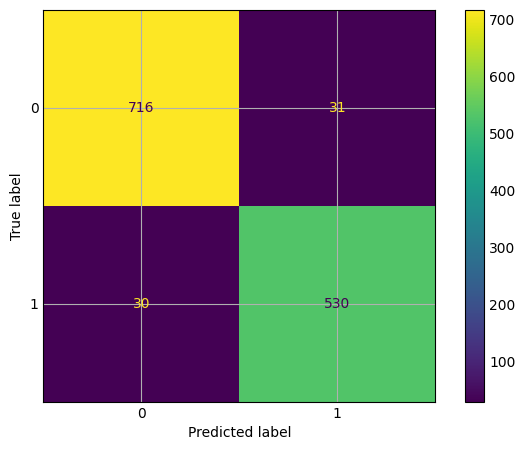

In [172]:
# Choose a threshold
threshold = 7.590396599057258

# Create predicted labels based on the chosen threshold
predicted_labels = [1 if x >= threshold else 0 for x in log_data]

fig, ax = plt.subplots(figsize=(6,4))
# Create the confusion matrix
cm = confusion_matrix(labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()
